# Consigna del desafío 4

Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.
- Extras que se pueden probar: Embeddings
pre-entrenados para los dos idiomas; cambiar la
estrategia de generación (por ejemplo muestreo
aleatorio);

## Importamos librerias

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
!pip install "numpy<2.0"

In [2]:
import re
import os
import gdown
import platform

import logging
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from pathlib import Path
from io import StringIO



In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Importamos el dataset

In [5]:
# Descargar la carpeta de dataset
#Dataset obtenido del repositorio de “Anki / ManyThings” (el proyecto “manythings.org”)
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /content/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:01<00:00, 2.11MB/s]


In [6]:
# Descargamos funciones auxiliares
if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

from torch_helpers import Tokenizer, pad_sequences

--2025-10-13 23:14:15--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2025-10-13 23:14:15--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2025-10-13 23:14:15 (140 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2025-10-13 23:14:15--
Total wall clock time: 0.4s
Downloaded: 1 files, 23K in 0s (140 MB/s)


### Definimos funciones auxiliares

In [7]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))

        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

## Preparamos los datos de entrada

In [8]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 7000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> fra
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 7000


In [9]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

In [10]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [11]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 4153
Sentencia de entrada más larga: 32


In [12]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 6246
Sentencia de salida más larga: 36


In [13]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 20
max_out_len = 20

In [14]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 7000
encoder_input_sequences shape: (7000, 20)
decoder_input_sequences shape: (7000, 20)


In [15]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (7000, 20)


In [16]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 20
decoder_input_size: 20
Output dim 6247


In [17]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 5600
Tamaño del conjunto de validacion: 1400


## Definicion del modelo

In [18]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
From (redirected): https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download&confirm=t&uuid=7889c262-5832-4690-b3dd-d1fcc9cdb829
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:06<00:00, 78.5MB/s]


In [19]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [20]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [21]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [22]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [23]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, lstm_size=128, num_layers=1):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, lstm_size=128, num_layers=1):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.fc1(lstm_output[:, -1, :])  # sin softmax
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)

        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random
            # para ver en cada vuelta que técnica se aplica
            #input = top1

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

## Entrenamos el modelo

### Encoder-Decoder con 128 de lstm_size

In [24]:
EPOCHS = 10

In [25]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Move input data to the device before passing it to summary
sample_encoder_input, sample_decoder_input, _ = data_set[0:1]
summary(model, input_data=(sample_encoder_input.to(device), sample_decoder_input.to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 20, 6247]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 20, 50]               (207,650)
│    └─LSTM: 2-2                         [1, 20, 128]              92,160
├─Decoder: 1-2                           [1, 6247]                 --
│    └─Embedding: 2-3                    [1, 1, 50]                312,350
│    └─LSTM: 2-4                         [1, 1, 128]               92,160
│    └─Linear: 2-5                       [1, 6247]                 805,863
├─Decoder: 1-3                           [1, 6247]                 (recursive)
│    └─Embedding: 2-6                    [1, 1, 50]                (recursive)
│    └─LSTM: 2-7                         [1, 1, 128]               (recursive)
│    └─Linear: 2-8                       [1, 6247]                 (recursive)
├─Decoder: 1-4          

In [26]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=EPOCHS
                )

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1/10 - Train loss 61.426 - Train accuracy 0.634 - Valid Loss 47.423 - Valid accuracy 0.641
Epoch: 2/10 - Train loss 42.266 - Train accuracy 0.684 - Valid Loss 45.558 - Valid accuracy 0.667
Epoch: 3/10 - Train loss 40.245 - Train accuracy 0.697 - Valid Loss 44.351 - Valid accuracy 0.680
Epoch: 4/10 - Train loss 38.492 - Train accuracy 0.708 - Valid Loss 42.960 - Valid accuracy 0.688
Epoch: 5/10 - Train loss 36.897 - Train accuracy 0.715 - Valid Loss 42.021 - Valid accuracy 0.691
Epoch: 6/10 - Train loss 35.457 - Train accuracy 0.721 - Valid Loss 41.050 - Valid accuracy 0.695
Epoch: 7/10 - Train loss 34.087 - Train accuracy 0.728 - Valid Loss 40.291 - Valid accuracy 0.705
Epoch: 8/10 - Train loss 32.814 - Train accuracy 0.732 - Valid Loss 39.677 - Valid accuracy 0.705
Epoch: 9/10 - Train loss 31.611 - Train accuracy 0.736 - Valid Loss 39.104 - Valid accuracy 0.709
Epoch: 10/10 - Train loss 30.430 - Train accuracy 0.740 - Valid Loss 38.670 - Valid accuracy 0.717


### Encoder-Decoder con 256 de lstm_size

In [27]:
encoder_2 = Encoder(vocab_size=nb_words, lstm_size=256)
if cuda: encoder_2.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_2 = Decoder(vocab_size=num_words_output, output_dim=num_words_output, lstm_size=256)
if cuda: decoder_2.cuda()

model_2 = Seq2Seq(encoder_2, decoder_2)
if cuda: model_2.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Move input data to the device before passing it to summary
sample_encoder_input, sample_decoder_input, _ = data_set[0:1]
summary(model_2, input_data=(sample_encoder_input.to(device), sample_decoder_input.to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 20, 6247]             --
├─Encoder: 1-1                           [1, 1, 256]               --
│    └─Embedding: 2-1                    [1, 20, 50]               (207,650)
│    └─LSTM: 2-2                         [1, 20, 256]              315,392
├─Decoder: 1-2                           [1, 6247]                 --
│    └─Embedding: 2-3                    [1, 1, 50]                312,350
│    └─LSTM: 2-4                         [1, 1, 256]               315,392
│    └─Linear: 2-5                       [1, 6247]                 1,605,479
├─Decoder: 1-3                           [1, 6247]                 (recursive)
│    └─Embedding: 2-6                    [1, 1, 50]                (recursive)
│    └─LSTM: 2-7                         [1, 1, 256]               (recursive)
│    └─Linear: 2-8                       [1, 6247]                 (recursive)
├─Decoder: 1-4      

In [28]:
history_2 = train(model_2,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=EPOCHS
                )

Epoch: 1/10 - Train loss 55.449 - Train accuracy 0.653 - Valid Loss 46.576 - Valid accuracy 0.653
Epoch: 2/10 - Train loss 41.189 - Train accuracy 0.690 - Valid Loss 44.203 - Valid accuracy 0.678
Epoch: 3/10 - Train loss 38.555 - Train accuracy 0.704 - Valid Loss 42.748 - Valid accuracy 0.684
Epoch: 4/10 - Train loss 36.396 - Train accuracy 0.713 - Valid Loss 41.534 - Valid accuracy 0.689
Epoch: 5/10 - Train loss 34.361 - Train accuracy 0.721 - Valid Loss 40.524 - Valid accuracy 0.700
Epoch: 6/10 - Train loss 32.361 - Train accuracy 0.728 - Valid Loss 39.560 - Valid accuracy 0.700
Epoch: 7/10 - Train loss 30.552 - Train accuracy 0.733 - Valid Loss 38.921 - Valid accuracy 0.713
Epoch: 8/10 - Train loss 28.825 - Train accuracy 0.739 - Valid Loss 38.436 - Valid accuracy 0.717
Epoch: 9/10 - Train loss 27.185 - Train accuracy 0.743 - Valid Loss 38.354 - Valid accuracy 0.717
Epoch: 10/10 - Train loss 25.593 - Train accuracy 0.749 - Valid Loss 38.062 - Valid accuracy 0.713


### Encoder-Decoder con 64 de lstm_size y 5 num_layers

In [29]:
encoder_3 = Encoder(vocab_size=nb_words, lstm_size=64, num_layers=5)
if cuda: encoder_3.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_3 = Decoder(vocab_size=num_words_output, output_dim=num_words_output, lstm_size=64, num_layers=5)
if cuda: decoder_3.cuda()

model_3 = Seq2Seq(encoder_3, decoder_3)
if cuda: model_3.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Move input data to the device before passing it to summary
sample_encoder_input, sample_decoder_input, _ = data_set[0:1]
summary(model_3, input_data=(sample_encoder_input.to(device), sample_decoder_input.to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 20, 6247]             --
├─Encoder: 1-1                           [5, 1, 64]                --
│    └─Embedding: 2-1                    [1, 20, 50]               (207,650)
│    └─LSTM: 2-2                         [1, 20, 64]               162,816
├─Decoder: 1-2                           [1, 6247]                 --
│    └─Embedding: 2-3                    [1, 1, 50]                312,350
│    └─LSTM: 2-4                         [1, 1, 64]                162,816
│    └─Linear: 2-5                       [1, 6247]                 406,055
├─Decoder: 1-3                           [1, 6247]                 (recursive)
│    └─Embedding: 2-6                    [1, 1, 50]                (recursive)
│    └─LSTM: 2-7                         [1, 1, 64]                (recursive)
│    └─Linear: 2-8                       [1, 6247]                 (recursive)
├─Decoder: 1-4        

In [30]:
history_3 = train(model_3,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=EPOCHS
                )

Epoch: 1/10 - Train loss 68.921 - Train accuracy 0.622 - Valid Loss 52.010 - Valid accuracy 0.617
Epoch: 2/10 - Train loss 45.279 - Train accuracy 0.659 - Valid Loss 48.989 - Valid accuracy 0.634
Epoch: 3/10 - Train loss 44.006 - Train accuracy 0.669 - Valid Loss 48.304 - Valid accuracy 0.641
Epoch: 4/10 - Train loss 43.450 - Train accuracy 0.670 - Valid Loss 48.187 - Valid accuracy 0.642
Epoch: 5/10 - Train loss 43.098 - Train accuracy 0.670 - Valid Loss 48.116 - Valid accuracy 0.644
Epoch: 6/10 - Train loss 42.834 - Train accuracy 0.670 - Valid Loss 48.090 - Valid accuracy 0.639
Epoch: 7/10 - Train loss 42.589 - Train accuracy 0.671 - Valid Loss 48.024 - Valid accuracy 0.644
Epoch: 8/10 - Train loss 42.390 - Train accuracy 0.671 - Valid Loss 47.920 - Valid accuracy 0.637
Epoch: 9/10 - Train loss 42.201 - Train accuracy 0.671 - Valid Loss 47.908 - Valid accuracy 0.639
Epoch: 10/10 - Train loss 42.036 - Train accuracy 0.671 - Valid Loss 47.864 - Valid accuracy 0.639


## Graficamos las metricas

### Grafico por modelo

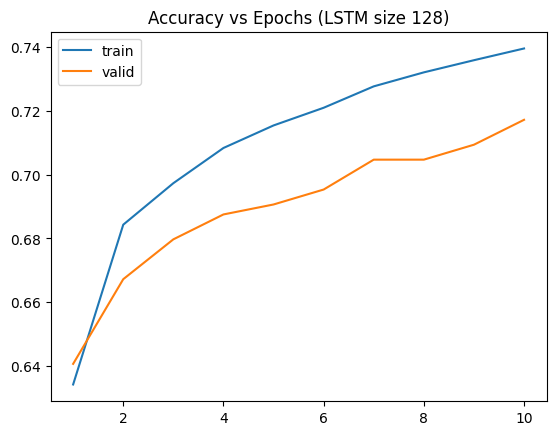

In [31]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.title('Accuracy vs Epochs (LSTM size 128)') # Added title here
plt.show()

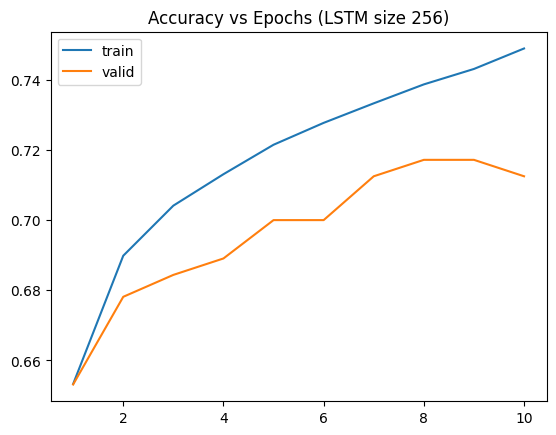

In [32]:
epoch_count = range(1, len(history_2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_2['val_accuracy'], label='valid')
plt.title('Accuracy vs Epochs (LSTM size 256)') # Added title here
plt.show()

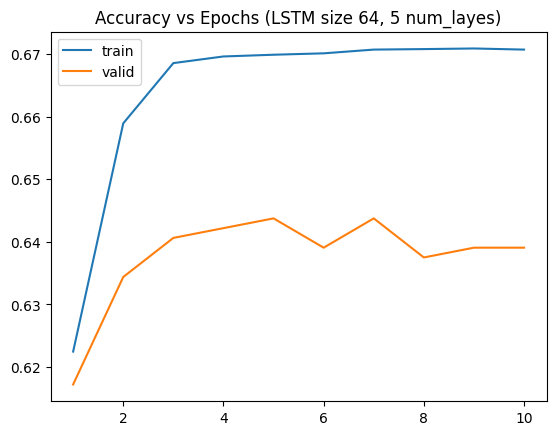

In [33]:
epoch_count = range(1, len(history_3['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_3['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_3['val_accuracy'], label='valid')
plt.title('Accuracy vs Epochs (LSTM size 64, 5 num_layes)') # Added title here
plt.show()

### Grafico comparacion entre modelos

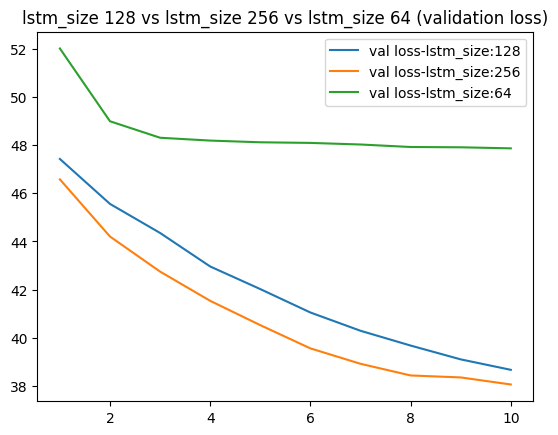

In [34]:
epoch_count = range(1, len(history_2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='val loss-lstm_size:128')
sns.lineplot(x=epoch_count,  y=history_2['val_loss'], label='val loss-lstm_size:256')
sns.lineplot(x=epoch_count,  y=history_3['val_loss'], label='val loss-lstm_size:64')
plt.title('lstm_size 128 vs lstm_size 256 vs lstm_size 64 (validation loss)') # Added title here
plt.show()

## Prueba

In [35]:
def translate_sentence(model, input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [36]:
for j in range(10):
    i = np.random.choice(len(input_sentences))
    input_seq = encoder_input_sequences[i:i+1]
    encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
    translation = translate_sentence(model, encoder_sequence_test_tensor)
    print(f'sentence {j+1}')
    print('----Input:', input_sentences[i])
    print('----Response:', translation)

sentence 1
----Input: Mary wants to buy a dress.
----Response: ella no tiene un poco de la puerta
sentence 2
----Input: Tom is naked.
----Response: tom es un poco
sentence 3
----Input: I can't hear you.
----Response: no estoy seguro
sentence 4
----Input: Your advice has been of great help.
----Response: no te gusta de la ciudad
sentence 5
----Input: Where is my seat?
----Response: no estoy seguro
sentence 6
----Input: My mother takes a nap every afternoon.
----Response: ella no tiene un poco de la ciudad
sentence 7
----Input: Don't pretend what you don't feel.
----Response: no te gusta a la casa
sentence 8
----Input: He is in good physical condition.
----Response: él es un poco de la ciudad
sentence 9
----Input: I'm sorry, but it's just not possible.
----Response: me gusta de que no me gusta la ciudad
sentence 10
----Input: What train you are going to take?
----Response: no me gustaría un poco de la ciudad


## Conclusion

En general, los tres modelos de traducción lograron resultados bastante estables, mostrando una buena convergencia a lo largo de las épocas. El modelo con lstm_size=128 y una sola capa tuvo un rendimiento muy equilibrado, alcanzando una precisión de validación cercana al 72% y una disminución progresiva de la pérdida, lo que sugiere que logró una buena representación de las secuencias sin sobreajustar. Al aumentar el tamaño del LSTM a 256 unidades, el modelo mejoró ligeramente en precisión y redujo la pérdida más rápido, aunque al final mostró signos leves de sobreajuste, lo que indica que ganó capacidad de aprendizaje pero con un costo en generalización. En cambio, el modelo más profundo, con 5 capas y 64 unidades por capa, fue el que menos rendimiento obtuvo: su precisión se mantuvo en torno al 64%, con una pérdida más alta y una evolución más lenta, lo que sugiere que la mayor profundidad complicó la optimización sin aportar beneficios reales. En conjunto, el modelo de 128 unidades se perfila como el más balanceado, combinando una buena precisión, estabilidad y eficiencia.

Aclaracion:
Se modifico el MAX_NUM_SENTENCES a 7000, se realizaron cambios menores en el codigo para que el modelo pueda entrenar y se elimino la funcion sofmax en el decoder ya que el CrossEntropyLoss ya incluye internamente un log_softmax, esto se hizo luego de observar que el modelo tendia a dejar de aprender e investigando se encontro que esto se puede deber a que los gradientes tiendan a cero cuando se aplicaban el softmax y el log_softmax.

tambien se cambiaron estos parametros max_input_len a 20  y max_out_len a 20 y el learning rate se bajo a 0.001.